# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 


Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* 		Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* 		Контролировать добросовестность кассиров при продаже алкоголя.


Наша задача - построить модель, которая по фотографии будет определять приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импорты

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных

In [21]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [22]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [23]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [24]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(dataframe=labels, 
                                       directory='/datasets/faces/final_files', 
                                       x_col='file_name', y_col='real_age', 
                                       target_size=(150, 150), batch_size=16, 
                                       class_mode='raw', seed=12345)

Found 7591 validated image filenames.


In [25]:
features, target = next(datagen_flow)

Признаки представляют собой тензор с размером батча 32 изображения 150x150 и тремя цветовыми каналами.

In [26]:
print(features.shape)
print(target.shape)

(16, 150, 150, 3)
(16,)


### Распределение возраста в выборке

In [27]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


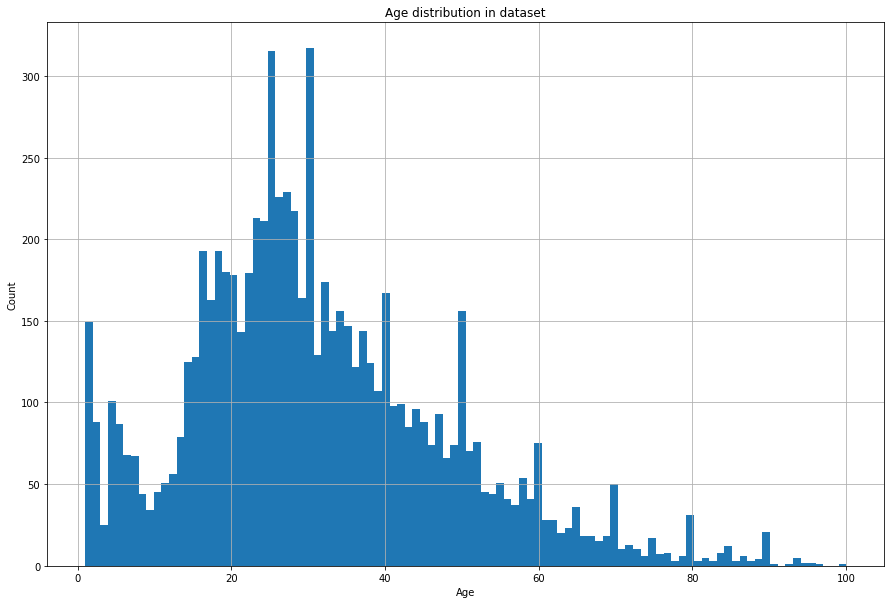

In [28]:
labels.hist(bins=100, figsize=(15,10))
plt.title('Age distribution in dataset')
plt.xlabel('Age')
plt.ylabel('Count');

Наша выборка содержит фотографии 7591 человека с возрастом от 1 до 100 лет. Средний возраст 31 год. Наибольшее число людей в выборке в возрасте от около 20 до около 50 лет. Так же можно отметить несколько выбросов в круглых значениях - 30, 40, 50 лет. Возможно, точно в этих случаях возраст не был точно установлен, и значение было округлено.

### Вывод фотографий

В подборке фотогрфий ниже можно заметить, что некоторые из них уже прошли преобработку, как минимум были повернуты.

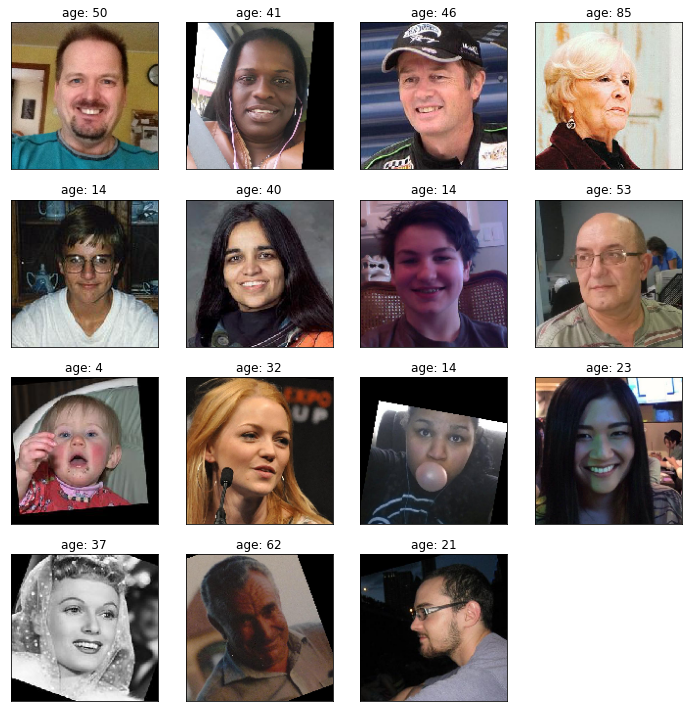

In [29]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В подборке фотогрфий ниже можно заметить, что некоторые из них уже прошли преобработку: на фотографиях четко определены лица, применен случайный кроп, фото повернуты так, чтобы лицо располагалось вертикально, есть черно-белые фото. 

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def load_train(path):

  train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)

  labels = pd.read_csv(path + 'labels.csv')

  train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                        directory = (path + 'final_files/'),
                                        x_col='file_name', y_col='real_age',
                                        target_size=(150, 150), batch_size=16,
                                        class_mode='raw', subset='training', seed=12345)

  return train_datagen_flow

def load_test(path):

  test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

  labels = pd.read_csv(path + 'labels.csv')

  test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                        directory = (path + 'final_files/'),
                                        x_col='file_name', y_col='real_age',
                                        target_size=(150, 150), batch_size=16,
                                        class_mode='raw', subset='validation', seed=12345)

  return test_datagen_flow

def create_model(input_shape):
  backbone = ResNet50(input_shape=input_shape,
                      weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False)

  model = Sequential()

  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))

  optimizer = Adam(lr=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

  return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

  model.fit(train_data,
            validation_data=test_data,
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2)

  return model

```

```

# < результат вывода на экран >
# < длинные строки со скачиванием модели удалены >


Epoch 1/10
356/356 - 74s - loss: 254.5530 - mae: 11.5275 - val_loss: 637.7782 - val_mae: 19.6630
Epoch 2/10
356/356 - 46s - loss: 90.8325 - mae: 7.2503 - val_loss: 231.2078 - val_mae: 11.3580
Epoch 3/10
356/356 - 53s - loss: 59.7610 - mae: 5.9201 - val_loss: 119.0757 - val_mae: 8.4984
Epoch 4/10
356/356 - 47s - loss: 43.7753 - mae: 5.0282 - val_loss: 83.8334 - val_mae: 6.8855
Epoch 5/10
356/356 - 45s - loss: 34.4593 - mae: 4.4654 - val_loss: 78.2816 - val_mae: 6.6895
Epoch 6/10
356/356 - 55s - loss: 24.6973 - mae: 3.7592 - val_loss: 74.3636 - val_mae: 6.5106
Epoch 7/10
356/356 - 54s - loss: 18.9715 - mae: 3.3038 - val_loss: 75.6853 - val_mae: 6.4018
Epoch 8/10
356/356 - 44s - loss: 15.5143 - mae: 2.9818 - val_loss: 79.0506 - val_mae: 6.6164
Epoch 9/10
356/356 - 45s - loss: 13.3893 - mae: 2.7879 - val_loss: 70.3317 - val_mae: 6.3415
Epoch 10/10
356/356 - 42s - loss: 12.9339 - mae: 2.7025 - val_loss: 70.5523 - val_mae: 6.2781

119/119 - 10s - loss: 70.5523 - mae: 6.2781
Test MAE: 6.2781

```

По итогам обучения нам удалось достичь необходимое целевое значение MAE ниже 8.

## Анализ обученной модели

Наша задача состояла в создании модели, которая по фотографии определяет приблизительный возраст человека.

В нашем распоряжении был набор из 7591 фотографий с указанием возраста изображенных на них людей. Возраст людей от 1 до 100 лет. Средний возраст в выборке - 31 год. Мы также отметили несколько выбросов в данных в значениях кратных 10. Это можно объяснить округлением этих значений, когда возраст невозможно было указать точно.

Также некоторые фотографии уже прошли предобработку.

Для обучения модели мы использовали сеть ResNet50. В итоге нам удалось достичь целевого показателя по MAE ниже 8 - 6.28. Однако ошибка в определении возраста в 6-6,5 лет делает модель непригодной для продажи товаров с жесткими возрастными ограничениями (алкоголь, сигареты), но может помочь при рекомендации товаров для более широких возрастных групп.